In this example, we will use the California housing dataset. In doing so, the dataset of train -, validation - and test data must be split into separate files. This is completely separate from the actual example and is done prior using the code below.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

In [ ]:
housing.target

In [ ]:
X_train_full[:1], y_train_full[:1]

In [ ]:
import numpy as np
from pathlib import Path

# Change the path_dir!!
path_dir = "./DL2024/housing/"

def save_to_csv_files(path_dir, data, name_prefix, header=None, n_parts=10):
    housing_dir = Path(path_dir)
    housing_dir.mkdir(parents=True, exist_ok=True)
    filename_format = "my_{}_{:02d}.csv"

    filepaths = []
    m = len(data)
    chunks = np.array_split(np.arange(m), n_parts)
    for file_idx, row_indices in enumerate(chunks):
        part_csv = housing_dir / filename_format.format(name_prefix, file_idx)
        filepaths.append(str(part_csv))
        with open(part_csv, "w") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([str(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_csv_files(path_dir, train_data, "train", header, n_parts=20)
valid_filepaths = save_to_csv_files(path_dir, valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_csv_files(path_dir, test_data, "test", header, n_parts=10)

# Loading and Preprocessing Data with TensorFlow

## Overview

- The data loading and preprocessing API is available in the `tf.data` package.
  - It is capable of loading and preprocessing data very efficiently.
  - It lets you handle datasets that are too large to fit in memory.
- `TFRecord` is a flexible and efficient binary format.
  - It usually contains protocol buffers.
  - We will not cover this in this course.
- Keras also provides a few preprocessing layers.
  - They can be embedded in a Keras model.


# 13.1 The `tf.data` API

## `tf.data.Dataset`

- A `tf.data.Dataset` represents a sequence of data items.
  - Usually datasets will gradually read the data from disk.
- One the next slide, we create a simple dataset using `tf.data.Dataset.from_tensor_slices`.
  - It takes a tensor and creates a `tf.data.Dataset` whose elements are all the slices of `X` (along the first dimension).

In [ ]:
import tensorflow as tf
import keras

In [ ]:
a =tf.range(5) #* np.arange(5), range(5)
b = keras.ops.arange(5)

a, b

In [ ]:
X = tf.range(10) # any data tensor
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

- You can then iterate over this dataset and process it like this:

In [ ]:
for item in dataset:
  print(item)

In [ ]:
X_nested = {"a": ([1, 2, 3], [4, 5, 6]), "b": [7, 8, 9]}
dataset = tf.data.Dataset.from_tensor_slices(X_nested)
for item in dataset:
    print(item)

## Example (Extra)

In a more realistic example, each example in the dataset will
have multiple features.  Here, we give an example where each
example has 3 features.

In [ ]:
# numpy
x1 = np.arange(10)

x2 = np.reshape(x1, (2, 5))

x1, x2

In [ ]:
Y = tf.reshape(tf.range(10*3), shape=(10,3)) # 10 rows, 3 columns
dataset = tf.data.Dataset.from_tensor_slices(Y)
for item in dataset:
  print(item)

- **Exercise**  
Write similar code to get the following result

```python  
tf.Tensor([0 1 2 3 4], shape=(5,), dtype=int32)
tf.Tensor([5 6 7 8 9], shape=(5,), dtype=int32)
tf.Tensor([10 11 12 13 14], shape=(5,), dtype=int32)
tf.Tensor([15 16 17 18 19], shape=(5,), dtype=int32)
tf.Tensor([20 21 22 23 24], shape=(5,), dtype=int32)
tf.Tensor([25 26 27 28 29], shape=(5,), dtype=int32)
tf.Tensor([30 31 32 33 34], shape=(5,), dtype=int32)
tf.Tensor([35 36 37 38 39], shape=(5,), dtype=int32)
```

In [ ]:
x = tf.reshape(tf.range(40), shape=(-1,5))
x
ds = tf.data.Dataset.from_tensor_slices(x)

for item in ds:
    print(item)

## Chaining Transformations

- You can apply all sorts of transformations on a
dataset by calling its transformation methods.
  *   Each method returns a new dataset.
  *   Transformations can be chained.




In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

- If you set `drop_remainder=True` on the `batch()`
method, then the last batch will be dropped if it is not
full.

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7, drop_remainder=True)
for item in dataset:
    print(item)

- **Exercise**  
Write code that produces
```python
tf.Tensor([0 1 2 3 4 5 6 0 1], shape=(9,), dtype=int32)
tf.Tensor([2 3 4 5 6 0 1 2 3], shape=(9,), dtype=int32)
tf.Tensor([4 5 6 0 1 2 3 4 5], shape=(9,), dtype=int32)
```

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(7))

dataset = dataset.repeat(4).batch(9, drop_remainder=True) #! Dataset is immutable

for item in dataset:
    print(item)

## Batching and Repeating

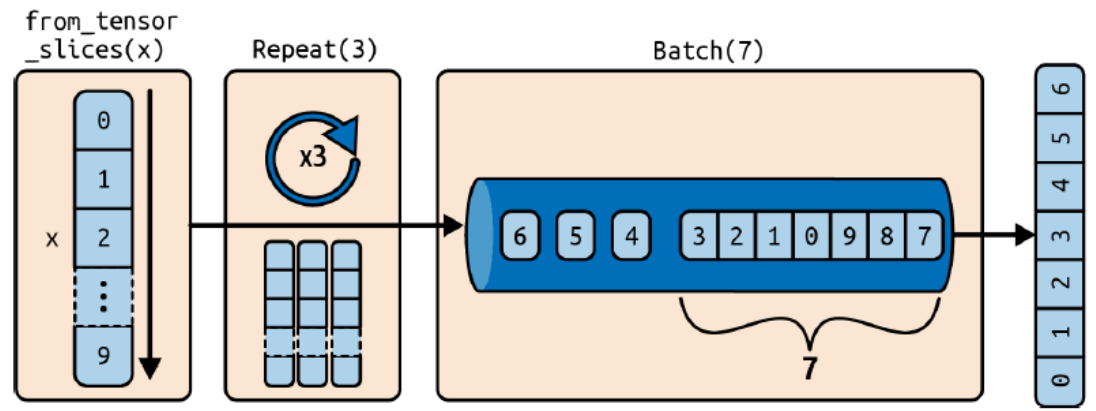

- **Remark  
The dataset methods do not modify datasets,
they create new ones! Make sure to create a
reference to these new datasets or else
nothing will happen.**

## `map` over a Dataset

In [ ]:
# as before, batches of 7 elements
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)

dataset = dataset.map(lambda x: x * 2)  # x is a batch
for item in dataset:
    print(item)

## `map` over a Dataset
- You can use multiple CPU cores by specifying
`num_parallel_calls`. Use `tf.data.AUTOTUNE` to
let TensorFlow decide how many threads to run.  
- An extra example is given below:


In [ ]:
# as before, batches of 7 elements
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7).map(lambda x: x * 2, num_parallel_calls=tf.data.AUTOTUNE)

def func (x):
  return tf.reduce_sum(x)>50

# dataset = dataset.map(func, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.filter(func)

for item in dataset:
  print(item)


- **Exercise**  
Multiply each value by 2 if the value is even and by 3 if the value is odd

In [ ]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7)
dataset = dataset.map(lambda x: tf.where(x % 2 == 0, x * 2, x * 3))

for item in dataset:
    print(item)

## `filter` on a Dataset

In [ ]:
# as before, batches of 7 elements
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7).map(lambda x: x * 2)

dataset = dataset.filter(lambda x: tf.reduce_sum(x) > 50)
for item in dataset:
    print(item)

- **Exercise**  
The minimum value of each tensor should be 2

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.repeat(3).batch(7).map(lambda x: x * 2)

dataset = dataset.filter(lambda x: tf.reduce_min(x) == 2)
for item in dataset:
    print("item: ", item)
    print("reduce min: ", tf.reduce_min(item))

## `take` on a Dataset
With `take` you can easily look at the first few
elements of a dataset.


In [ ]:
for item in dataset.take(2):
    print(item)

In [ ]:
ds = tf.data.Dataset.from_tensor_slices([4,6,3])
for item in ds:
    print(item)

## Shuffling the Data

- Gradient descent works best when the training
samples are independent and identically distributed
(IID).

  *   This is why we usually shuffle the training set.
  *   This ensures that any “order” that may have been present
  in the data is removed.

- The `shuffle` method creates a new dataset that will
start by filling up a buffer with the first items of the
source dataset.
  * Then, whenever it is asked for an item, it will pull one out
  randomly from the buffer and replace it with the first
  element not in the buffer from the source dataset, until it
  has iterated through the source dataset once.
  * The `buffer_size` argument controls the size of the
  buffer.

- The value for `buffer_size` must be large enough or
shuffling will not be very effective

- The use of `seed` ensures the same 'random' order at each run.



In [ ]:
dataset = tf.data.Dataset.range(10).repeat(2)
dataset = dataset.shuffle(buffer_size=4, seed=42).batch(7)
for item in dataset:
    print(item)

In [ ]:

#* Uses a buffer, that is smaller than the dataset to shuffle the dataset,
#* so that not all elements are in memory at once
ds = ds.shuffle(buffer_size=4)

for item in ds:
    print(item)

In [ ]:
dataset1 = tf.data.Dataset.range(10)
dataset2 = dataset1.repeat(2)
dataset3 = dataset1.shuffle(buffer_size=4, seed=42)

dataset1, dataset2, dataset3

**Repeating a Shuffled Dataset**

- If you call `repeat()` after `shuffle()`, you will get a
different order at each iteration.
  * This is generally a good idea.
  * However, if you set `reshuffle_each_iteration=False`,
  then the order will be the same at each iteration.


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.shuffle(buffer_size=10, seed=42)
dataset = dataset.repeat(2) # repeat shuffled dataset
for index, item in enumerate(dataset):
  print(item.numpy(), end= " ")
  if index == 9: # Newline after first iteration
    print()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(tf.range(10))
dataset = dataset.shuffle(buffer_size=10, seed=42, reshuffle_each_iteration=False)
dataset = dataset.repeat(2) # repeat shuffled dataset
for index, item in enumerate(dataset):
  print(item.numpy(), end= " ")
  if index == 9: # Newline after first iteration
    print()

# Interleaving Lines from Multiple Files

**Setup**

- In the beginning of this notebook
  - The California housing dataset was split into a training, validation and test set.
  - Each set was split into many CSV files.
- Let's suppose `train_filepaths` contains the list of training file paths


In [ ]:
import os
# directory_path = '/content/drive/MyDrive/Colab Notebooks/DL2024/housing/'
path_dir = "./DL2024/housing/"

file_names = os.listdir(path_dir)
train_filepaths = [path_dir + f for f in file_names if f.startswith('my_train')]

In [ ]:
train_filepaths

- **Exercise**  
Write similar code for `valid_filepaths` and `test_filepaths`

In [ ]:
test_filepaths = [path_dir + f for f in file_names if f.startswith('my_test')]

In [ ]:
valid_filepaths

In [ ]:
test_filepaths

## Step 1: Create a Dataset of File Paths

- Use the `list_files` static method on Dataset to
create a dataset containing these file paths.

In [ ]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

for filepath in filepath_dataset:
    print(filepath)

- Note: the filepaths are shuffled by default! Set
`shuffle=False` if you don't want this.

In [ ]:
for filepath in filepath_dataset.take(2):
  print(filepath)

- According to the TensorFlow documentation, the `list_files` method should *not* be used with a large number of files. Instead, use a "glob" pattern:

In [ ]:
# Better way
import glob
filepath_dataset = tf.data.Dataset.list_files("DL2024/housing/*.csv", seed=42)
filepaths = glob.glob(path_dir + "*.csv")


for filepath in filepath_dataset:
    print(filepath)

## Step 2: Read from Multiple Files

- The `interleave` can be called to read from multiple files simultaneously.
    - For `interleave` we need a `map_func` that takes a dataset item (in this case, a file path) and returns a Dataset.
    - In this case we will create a `TextLineDataset` for each file path and skip the first line (header row).
    - `cycle_length` controls the number of files to read in parallel.
  
- Iterating over this dataset will result in lines from 5 different files being read and interleaved.
- Then, another five (random) files will be read, and so on until all files are read.
- Note: interleaving works best if the files have identical length; the end of longest file will not be interleaved

In [ ]:
path = "./DL2024/housing/my_train_06.csv"
text_ds = tf.data.TextLineDataset(path)

for item in text_ds.skip(1):  #? skip header
    print(item)

In [ ]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)
for line in dataset.take(5):
  print(line)

## 13.1.4 Preprocessing the Data

## Preprocessing the Data

- At this point the dataset is returned as byte strings.
  - We want to convert these into numerical tensors, and also scale the inputs.


- `decode_csv` takes a line (a tensor of type string) and  a list of default values for each column (a list of tensors, one per column)
  - In this case the default values are all 0.0, except for the last one which doesn't have a default value.
- `decode_csv` returns a list of Tensor objects.
  - We want two (array) tensors: one containing the features, and one containing the labels: `stack` does this.
- The `preprocess` function is easy: it simply takes a line (a String Tensor), parses it, and scales the features.
  - A tuple containing the scaled features and the label is returned.

- **Exercise**  
Calculate X_mean en X_std (i.e. the mean and standarddeviation of the features of X_train)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train)

X_mean, X_std = scaler.mean_, scaler.scale_
X_mean, X_std

In [ ]:

#? Same as above
import keras

norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
norm_layer.mean

In [ ]:
# mean and standard deviation for each feature in the training set
X_mean, X_std = scaler.mean_, scaler.scale_  # extra code
n_inputs = 8

def parse_csv_line(line):
    """ Parses csv line to tensor
    """
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    # list of tensors, one per column
    fields = tf.io.decode_csv(line, record_defaults=defs)
    return tf.stack(fields[:-1]), tf.stack(fields[-1:])

def preprocess(line):
    x, y = parse_csv_line(line)
    return (x - X_mean) / X_std, y

In [ ]:
parse_csv_line(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

## Test the `preprocess` function

In [ ]:

#? First values in the tuple are the features, last value is the label
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

## 13.1.5 Putting Everything Together

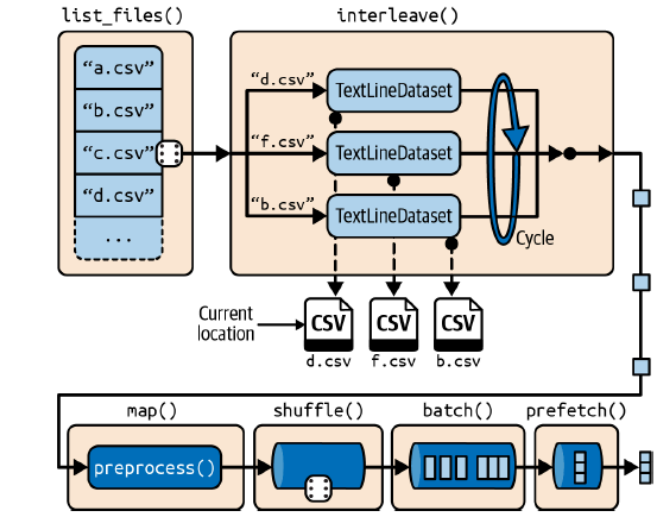

In [ ]:
def csv_reader_dataset(filepaths, n_readers=5, n_read_threads=None,
                       n_parse_threads=5, shuffle_buffer_size=10_000,
                       seed=42, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths, seed=seed)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.shuffle(shuffle_buffer_size, seed=seed)
    return dataset.batch(batch_size).prefetch(1)

- **Exercise**  
show the first 2 batches produced by the training dataset

## 13.1.6 Prefetching

## Prefetching

- By calling `prefetch(1)` at the end of the `csv_reader_dataset` function, we are creating a dataset that will do its best to always be one batch ahead.
  - While the training algorithm is working on one batch, the dataset will already be working in parallel on getting the next batch ready.
- If preparing the next batch is shorter than running a training step on the GPU, then the GPU will be almost 100% utilized.
  - "Almost": because data needs to be transferred from the CPU to the GPU.

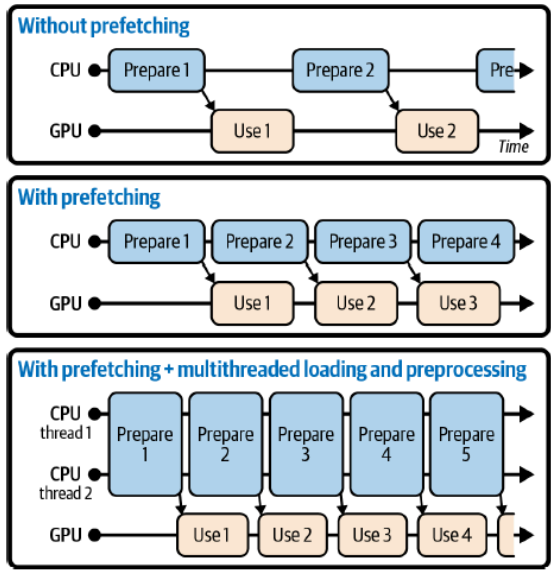


## Caching a Dataset

- If the Dataset is small enough to fit into memory, calling `cache()` on it will cache its content in RAM.
  - This will speed up the training by a lot.
- Typically you call `cache` after loading and preprocessing, but before shuffling and batching.
  - This way the data will only be loaded and preprocessed once (instead of once per epoch).    


## 13.1.7 Using the Dataset with Keras



- **Exercise**
Create `train_set`, `valid_set`, `test_set`

In [ ]:
train_ds = csv_reader_dataset(train_filepaths)
valid_ds= csv_reader_dataset(valid_filepaths)
test_ds = csv_reader_dataset(test_filepaths)

train_ds, valid_ds, test_ds

## Training the Model

- We can now pass `train_set` instead of `X_train` and `y_train`.
- Similarly, we can pass `validation_data=valid_set` instead of `validation_data=(X_valid, y_valid)`.
- `fit` will repeat the training set once per epoch.
  - If will use a different random order at each epoch.

- **Exercise**  
Create, compile and train a simple model with 1 hidden layer
  - number of neurons = 30
  - activation = relu
  - kernel_initializer = he_normal  

  Which loss function you will use?

In [ ]:

model = keras.Sequential()
model.add(keras.Input(shape=(8,)))
model.add(keras.layers.Dense(30, activation='relu',kernel_initializer='he_normal'))
model.add(keras.layers.Dense(1)) #* Output layer -> regression model

model.compile(loss='mse', optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [ ]:
model.fit(train_ds, validation_data=valid_ds,epochs=10)

## Evaluating and Making Predictions

- Of course, you can also use `Dataset`s for evaluation.
  - You can pass a `Dataset` to `evaluate` instead of `X_test` and `y_test`.

- Note, normally the `Dataset` passed to `predict` doesn't contain labels.
  - Here, the labels _are_ present but Keras ignores them in this case.

- **Exercise**
  - Evaluate the model using the test data
  - Create a `new_set` which contains the first 3 batches
  - Use this `new_set` to make predictions

In [119]:
model.evaluate(test_ds)

162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.2734


2025-10-30 11:48:45.267707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2025-10-30 11:48:45.267726: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2025-10-30 11:48:45.267730: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 16156558588238023227
2025-10-30 11:48:45.267733: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13377199522745162901
2025-10-30 11:48:45.267739: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6107192732824848814


12.273411750793457

## Remove the Labels (Extra)

- The labels can be removed by using the `map` method and selecting
only the first item of the tuples in the dataset.

- **Exercise**   
Remove the labels from the `new_set`.

# 13.2 The `TFRecord` Format

# 13.3 Keras Preprocessing Layers

## Preprocessing Options

Preparing data for a neural network typically requires a lot of preprocessing: normalizing, scaling, encoding categorical features, cropping and resizing images and so on.

- Do the preprocessing outside of the model, using NumPy arrays or pandas DataFrames, Scikit-Learn, etc.
  - You will need the exact same steps in production!
- Preprocess on the fly while loading the data, e.g. using `tf.data` and applying a preprocessing function using the `map` method.
  - Again, you will need the exact same preprocessing steps in production!
- Include the preprocessing layers inside your model and preprocess the data on the fly during training.
  - You can use the exact same preprocessing layers in production.


## 13.3.1 The `Normalization` Layer

## Including the `Normalization` Layer in the Model

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
norm_layer = keras.layers.Normalization()
model = keras.models.Sequential([
    norm_layer, #! normalization layer *inside* the model
    keras.layers.Dense(1)
])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=2e-3))

norm_layer.adapt(X_train)  #? computes the mean and variance of every feature
model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5)

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 3.6276 - val_loss: 1.5361
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8433 - val_loss: 0.7910
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6566 - val_loss: 0.7005
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6195 - val_loss: 0.6991
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6007 - val_loss: 0.6836


## Avoid Data Leakage (Extra)

- Note how the normalization layer is adapted to the *training data* only.
  - This avoids data leakage.

## Preprocessing inside the Model

Using a preprocessing layer inside the model can be visiualized as follows:
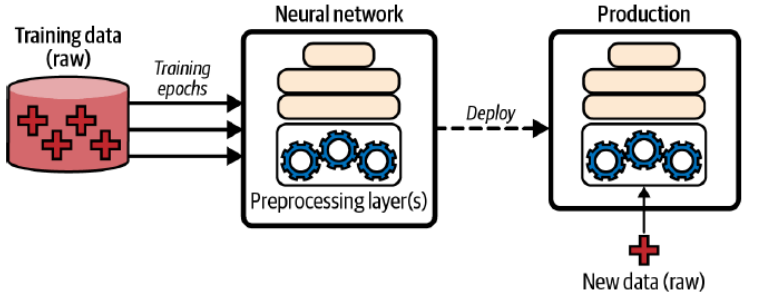


## Preprocessing before Training

- Performing the normalization inside the model will slow down training.
  - Data is normalized once per epoch!
- It is more efficient to normalize all the data before training.
  - Model can be trained _without_ the normalization layer.
  - This will be faster.
- Finally, create a new model with the normalization layer and use it to make predictions on new instances.
  - This avoids preprocessing mismatch at prediction time.

## Including the Preprocessing Layers after Training

Using a preprocessing layer after training can be visiualized as follows:
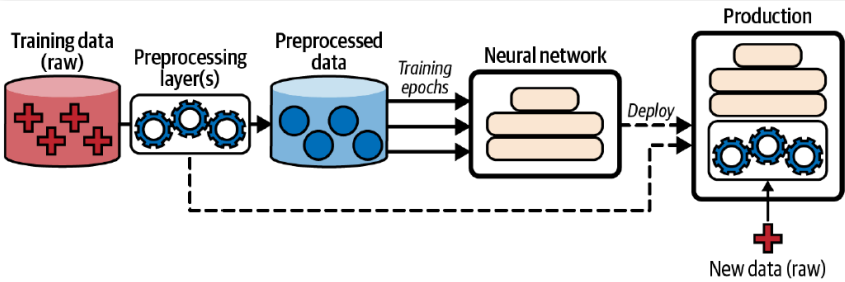

In [121]:
# Step 1: preprocess the data
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train)
X_train_scaled = norm_layer(X_train) # call layer as a function
X_valid_scaled = norm_layer(X_valid)

# Step 2: train the model
model = keras.models.Sequential([keras.layers.Dense(1)])
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=2e-3))
model.fit(X_train_scaled, y_train, epochs=5, validation_data=(X_valid_scaled, y_valid))

# Step 3: Create a model for production.
final_model = keras.Sequential([norm_layer, model])

Epoch 1/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.6055 - val_loss: 1.9259
Epoch 2/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7870 - val_loss: 0.8128
Epoch 3/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6541 - val_loss: 0.7755
Epoch 4/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6253 - val_loss: 0.7281
Epoch 5/5
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6072 - val_loss: 0.7008


## Interaction with `tf.data.Dataset`

Preprocessing layers work seamlessly with `tf.data.Dataset` objects.

Note: if this dataset fits into RAM you should probably `cache()` it after the `map()` call.

In [122]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(5)
dataset = dataset.map(lambda X, y: (norm_layer(X), y))

## 13.3.2 The `Discretization` Layer

## The `Discretization` Layer

- The goal of this layer is to transform a numerical feature into a categorical feature through the process of **binning**.
  - Can be useful with multimodal distributions or features with a highly non-linear relationship with the target.
- You can either provide the bin boundaries yourself, or you can let `adapt()` find the boundaries based on the value percentiles.

In [ ]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
#? Bin boundaries to discretize ages into 3 categories: <18, 18–50, >50
discretize_layer = keras.layers.Discretization(bin_boundaries=[18., 50.])
# Note! NO adapt needed, because bin boundaries are provided.
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[0],
       [2],
       [2],
       [1],
       [1],
       [0]])>

- **Exercise**  
Try to predict the result for
```python
age = tf.constant([[65.], [78.], [20.], [38.], [10.]])
discretize_layer = keras.layers.Discretization(bin_boundaries=[25., 50., 75.])
```


In [ ]:
age = tf.constant([[65.], [78.], [20.], [38.], [10.]])
#! Bin boundaries to discretize ages into 4 categories: <25, 25–50, 50–75, >75
discretize_layer = keras.layers.Discretization(bin_boundaries=[25., 50., 75.])
#* Prediction:
#*             | 25.         | 50.        | 75.
#* ------------|-----------|------------|--------
#*              65                                  [2]
#*                                        78.       [3]
#* 20                                               [0]
#*               38                                 [1]
#* 10                                               [0]
# Note! NO adapt needed, because bin boundaries are provided.
age_categories = discretize_layer(age)
age_categories

[25.0, 50.0, 75.0]

In [125]:
age = tf.constant([[10.], [93.], [57.], [18.], [37.], [5.]])
discretize_layer = keras.layers.Discretization(num_bins=3)
discretize_layer.adapt(age) # finds the boundaries based on the data
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(6, 1), dtype=int64, numpy=
array([[1],
       [2],
       [2],
       [1],
       [2],
       [0]])>

- **Exercise**  
Try to predict the result for
```python
age = tf.constant([[65.], [78.], [20.], [38.], [10.]])
discretize_layer = keras.layers.Discretization(num_bins=4)
```

In [126]:
age = tf.constant([[65.], [78.], [20.], [38.], [10.]])
discretize_layer = keras.layers.Discretization(num_bins=4)
discretize_layer.adapt(age) # finds the boundaries based on the data
age_categories = discretize_layer(age)
age_categories

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[3],
       [3],
       [1],
       [2],
       [0]])>

## 13.3.3 The CategoryEncoding Layer

## One-Hot Encoding

- When the number of categories is limited then often one-hot encoding is a good option.
- keras provides a `CategoryEncoding` layer for this purpose.

In [ ]:
age_categories = tf.constant([[0],[2],[2],[1],[2],[0]]) # shape (6,1)
onehot_layer = keras.layers.CategoryEncoding(num_tokens=3)
onehot_layer(age_categories)

## 13.3.4 The StringLookup Layer

## The `StringLookup` Layer

- `StringLookup` is used to (one-hot) encode categorical String features.
- You need to `adapt` it to the data.
- You then use the layer to encode Strings:
  - Unknown categories are mapped to 0.
  - Known categories are numbered from 1, from the most frequent to the least frequent.

In [ ]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
str_lookup_layer = keras.layers.StringLookup()
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

- **Exercise**  
Try to predict the result for
```python
countries = ["UK", "Belgium", "The Netherlands", "UK", "Belgium", "UK"]
str_lookup_layer = keras.layers.StringLookup()
str_lookup_layer.adapt(countries)
str_lookup_layer([["Belgium"], ["France"], ["The Netherlands"], ["UK"]])
```

## `StringLookup` with One-Hot Encoding

If you set `output_mode="one_hot"` then the layer will output a one-hot vector for each instance.

In [ ]:
cities = ["Auckland", "Paris", "Paris", "San Francisco"]
# Set output_mode="one_hot" to get one-hot vectors.
str_lookup_layer = keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(cities)
str_lookup_layer([["Paris"], ["Auckland"], ["Auckland"], ["Montreal"]])

- **Exercise**  
Try to predict the result for
```python
countries = ["UK", "Belgium", "The Netherlands", "UK", "Belgium", "UK"]
str_lookup_layer = keras.layers.StringLookup(output_mode="one_hot")
str_lookup_layer.adapt(countries)
str_lookup_layer([["Belgium"], ["France"], ["The Netherlands"], ["UK"]])
```

## Number of OOV-Indices

- By default, the `StringLookup` layer will only use index zero for the out-of-vocabulary (OOV) category.
  - Thus, each unknown word gets mapped to zero.
  - This makes all these words indistinguishable.
- You can use more OOV-indices by setting `num_oov_indices` to a value greater than one.

In [ ]:
str_lookup_layer = keras.layers.StringLookup(num_oov_indices=5)

- **Exercise**  
Try to predict the result for
```python
countries = ["UK", "Belgium", "The Netherlands", "UK", "Belgium", "UK"]
str_lookup_layer = keras.layers.StringLookup(num_oov_indices=3, output_mode="one_hot")
str_lookup_layer.adapt(countries)
str_lookup_layer([["Belgium"], ["France"], ["The Netherlands"], ["UK"]])
```

## 13.3.5 The Hashing Layer

## The `Hashing` Layer

- The `Hashing` layer assigns categories to buckets or bins using a hash function.
  - The mapping is pseudo-random, but stable across runs and platforms. I.e. the same category will always be assigned to the same bucket.
- This layer does *not* need to be adapted to the data.

In [ ]:
hashing_layer = keras.layers.Hashing(num_bins=10)
hashing_layer([["Paris"], ["Tokyo"], ["Auckland"], ["Montreal"]])

Note how "Tokyo" and "Montreal" are mapped to the same bucket. This is a _hashing collision_.

## 13.3.6 Encoding Categorical Features Using Embeddings

##  Embeddings

- An **embedding** is a dense representation of some high(er)-dimensional data, such as a category or a word (in a vocabulary).
- If the number of categories is very large, e.g. 50,000 words in a vocabulary, then it is not feasible to use one-hot encoding.
  - The one-hot vector would have 50,000 dimensions, and all but one of the dimensions would be zero.
  - This is very inefficient.
- An embedding by contrast is a much smaller (e.g. 100 dimensions) but dense vector.

## Trainable Embeddings

- In deep learning, embeddings are typically initialized randomly and then trained to fit the data.
  - Thus, the embedding is **trainable**.
  - Typically, categories with similar meaning will have similar embeddings.
  - E.g. in the California housing dataset, the categories "NEAR OCEAN" and "NEAR BAY" will (probably) end up with similar embeddings.
- This is called **representation learning**.
  - The model learns a representation of the data that is useful for the task at hand. How embeddings improve during training is visualized as follows:

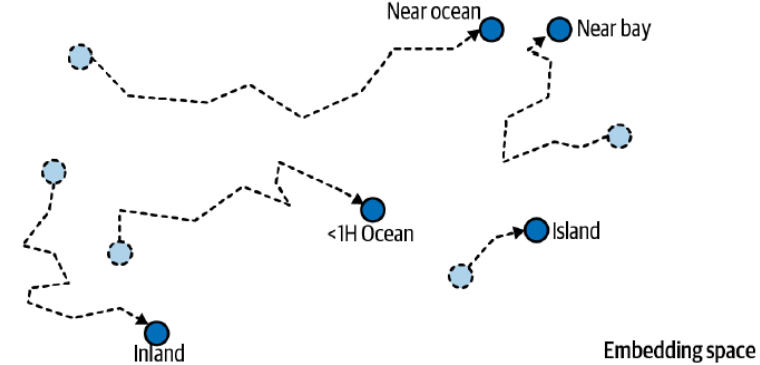

## The `Embedding` Layer

- Keras provides an `Embedding` layer, which wraps the **embedding matrix**.
  - This matrix has one row per category (e.g. per word in the vocabulary), and one column per embedding dimension.
  - Thus, if we have 50000 words and the embedding dimension is 100, then the embedding matrix will have shape `(50000, 100)`.
- Converting a category ID to its embedding is simply looking up the corresponding row in the embedding matrix.

## Example of `Embedding` layer

- In the code below, we initialize an embedding layer to embed 5 categories into 2 dimensions,
and use it to embed the category IDs 2, 4, and 2.
- The embedding dimension is a
hyperparameter that you can tune.
Embeddings typically have 10 to 300
dimensions, depending on the task, the
vocabulary size, and the amount of training
data available.



In [ ]:
tf.random.set_seed(42)
embedding_layer = keras.layers.Embedding(input_dim=5, output_dim=2)
embedding_layer(np.array([2, 4, 2]))

## Example of `Embedding` layer (Extra)

- The `Embedding` layer simply wraps the embedding matrix.
- We can get the embedding matrix using the `get_weights()` method.

In [ ]:
embedding_layer.get_weights()[0]

## Embedding Categorical Text

- To embed a categorical text feature, first encode it using a `StringLookup` layer, then embed it using an `Embedding` layer.
- Note the use of `vocabulary_size()` to get the number of categories and use it as the input dimension of the `Embedding` layer.

In [ ]:
ocean_prox = ["<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", "ISLAND"]

str_lookup_layer = keras.layers.StringLookup()
str_lookup_layer.adapt(ocean_prox)
# Eerst woorden omzetten naar getallen, dan pas Embedding!
lookup_and_embed = keras.Sequential([
  keras.layers.Input(shape=[], dtype=tf.string),
  str_lookup_layer,
  keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),output_dim=2)
])


In [ ]:
lookup_and_embed(np.array(["<1H OCEAN", "ISLAND", "<1H OCEAN"]))

## Larger Example

- Let's create a model that can process a categorical text feature along with regular numerical features.
  - The model will learn an embedding for each category.
- Start by loading the training and validation data sets.

In [ ]:
# Load the insurance dataset
import pandas as pd

# Load the dataset
# The insurance dataset contains information on the relationship between personal attributes
# (age, gender, BMI, family size, smoking habits), geographic factors, and their impact on medical insurance charges.
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DL2024/insurance.csv")
data.head()

- **Exercise**  
Use Binary encoding for sex and smoker

In [ ]:
# Binary encoding for sex and smoker


In [ ]:
# Define the numerical and categorical feature column names
numerical_features = ['age', 'sex', 'bmi', 'children', 'smoker']
categorical_features = ['region']
target_column = ['charges']

train_data, valid_data = train_test_split(data, test_size=0.2, random_state=42)

# Separate features and target for training and validation sets
X_train_num = train_data[numerical_features].to_numpy()    # Numerical features for training
X_train_cat = train_data[categorical_features].to_numpy()    # Categorical features for training
y_train = train_data[target_column].to_numpy()             # Target for training

X_valid_num = valid_data[numerical_features].to_numpy()      # Numerical features for validation
X_valid_cat = valid_data[categorical_features].to_numpy()    # Categorical features for validation
y_valid = valid_data[target_column].to_numpy()              # Target for validation

- **Exercise**  
Write code to create an Embedding for the regions. A region is represented by 3 floats.  
Write testcode to check the Embedding.

In [ ]:
num_input = keras.layers.Input(shape=[5], name="num")
cat_input = keras.layers.Input(shape=[], dtype=tf.string, name="cat")
# Embed categorical input using lookup_and_embed layer defined above.
cat_embeddings = lookup_and_embed(cat_input)
# Concatenate the numerical and categorical inputs.
encoded_inputs = keras.layers.concatenate([num_input, cat_embeddings])
# Add a dense output layer.
outputs = keras.layers.Dense(1)(encoded_inputs)
# Create the model by specifying the inputs and outputs.
model = keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])


In [ ]:
# compile and train the model as usual
model.compile(loss="mse", optimizer="sgd")
history = model.fit((X_train_num, X_train_cat), y_train, epochs=5,
                    validation_data=((X_valid_num, X_valid_cat), y_valid))

- **Exercise**  
The model is not working. Use a Normalization layer for both numerical input features and target values in order to make the model work.

In [ ]:
# Step 1.a: preprocess the data
norm_layer = keras.layers.Normalization()
norm_layer.adapt(X_train_num)
X_train_scaled = norm_layer(X_train_num) # call layer as a function
X_valid_scaled = norm_layer(X_valid_num)

# Step 1.b: preprocess the target
norm_layer_target = keras.layers.Normalization()
norm_layer_target.adapt(y_train)
y_train_scaled = norm_layer_target(y_train) # call layer as a function
y_valid_scaled = norm_layer_target(y_valid)


regions =  data['region'].unique()

str_lookup_layer = keras.layers.StringLookup()
str_lookup_layer.adapt(regions)
lookup_and_embed = keras.Sequential([
  keras.layers.Input(shape=[], dtype=tf.string),
  str_lookup_layer,
  keras.layers.Embedding(input_dim=str_lookup_layer.vocabulary_size(),output_dim=3)
])


# Step 2: train the model
num_input = keras.layers.Input(shape=[5], name="num")
cat_input = keras.layers.Input(shape=[], dtype=tf.string, name="cat")
# Embed categorical input using lookup_and_embed layer defined above.
cat_embeddings = lookup_and_embed(cat_input)
# Concatenate the numerical and categorical inputs.
encoded_inputs = keras.layers.concatenate([num_input, cat_embeddings])
# Add a dense output layer.
outputs = keras.layers.Dense(1)(encoded_inputs)
# Create the model by specifying the inputs and outputs.
model = keras.models.Model(inputs=[num_input, cat_input], outputs=[outputs])

X_train_cat = keras.ops.cast(X_train_cat, tf.string)
X_valid_cat = keras.ops.cast(X_valid_cat, tf.string)

# compile and train the model as usual
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=2e-3))
history = model.fit((X_train_scaled, X_train_cat), y_train_scaled, epochs=5,
                    validation_data=((X_valid_scaled, X_valid_cat), y_valid_scaled))


## 13.3.7 Text Preprocessing

## The `TextVectorization` Layer

- Keras provides the `TextVectorization` layer for basic text preprocessing.
- You must either
  - pass a vocabulary upon creation,
  - or use the `adapt()` method to let it learn the vocabulary from some training data.
- We can inspect the vocabulary using the `get_vocabulary()` method.
- Note that
  - The padding token comes first.
  - The unknown token comes second.
  - The most common word is “be”.

In [ ]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = keras.layers.TextVectorization()
text_vec_layer.adapt(train_data) # construct vocabulary
text_vec_layer.get_vocabulary()

In [ ]:
text_vec_layer(train_data)

In [ ]:
text_vec_layer(["Be good!", "Question: be or be?"])

- To construct the vocabulary, the sentences are converted to lowercase and punctuation is removed by default.
- Next, the sentences are split on whitespace.
- The resulting words are sorted by descending frequency.
  - The most common word gets encoded as 2.
  - 1 is reserved for out-of-vocabulary words.
  - 0 is reserved for padding.


- **Exercise**  
What will be the result of
```python
train_data = ["ik eet een appel en een peer", "soms eet ik een banaan", "hij eet weer een peer"]
text_vec_layer = keras.layers.TextVectorization()
text_vec_layer.adapt(train_data) # construct vocabulary
text_vec_layer(["een peer of een banaan", "meneer eet een peer"])
```

In [ ]:
train_data = ["ik eet een appel en een peer", "soms eet ik een banaan", "hij eet weer een peer"]
text_vec_layer = keras.layers.TextVectorization()
text_vec_layer.adapt(train_data) # construct vocabulary

## TF-IDF Encoding

- The `TextVectorization` layer can also perform TF-IDF encoding.
- This is an alternative to simply counting the words.
  - Counting words is not ideal: words like "to" and "the" are so frequent that they don't matter at all (for the meaning of the sentence or document).
  - Rarer words, like "basketball" are much more informative.
- **TF-IDF** stands for **term frequency-inverse document frequency**.
  - TF-IDF encoding gives a score to each word in each sentence or document.
  - The more often it appears in the sentence, the higher the score; the more often it appears in the corpus, the lower the score.

In [ ]:
train_data = ["To be", "!(to be)", "That's the question", "Be, be, be."]
text_vec_layer = keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer.get_vocabulary()

- Note that in this case the vocabulary does not include a "padding" token.
- In TF-IDF mode, each sentence is represented by a **sparse** tensor with length equal to the vocabulary size.
- This is why the result has 6 columns.

## TF-IDF Computation

In the example above,

- we trained the `TextVectorization` layer on 4 sentences (or documents), so $d = 4$.
- The weight for each word is computed as follows:
  $$
  \mathrm{idf} = \log(1 + d / (f + 1))
  $$
  where $d$ is the number of documents and $f$ is the number of documents that contain the word.
- E.g. for the word "be" this idf is
$$
\mathrm{idf} = \log(1 + 4 / (3 + 1)) = 0.693
$$  

- The word "be" appears twice in the sentence "Question: be or be?", so its term frequency is 2.
- The word "be" in this sentence hence gets encoded as $2\times 0.693 \approx 1.386$.  
- The word "question" only appears once in the sentence, but its weight is $\log(1 + 4 /(1 + 1)) \approx 1.099$.
- The vocabulary (including the "[UNK]" word) contains 6 words.
  - This is way the result has 6 columns.
- For unknown words, the average idf-weight is used.

In [ ]:
text_vec_layer(train_data)

- **Exercise**  
Calculate the scores for this vocabulary, usint tf-idf.  
What will be the result of
```python
train_data = ["ik eet een appel en een peer", "soms eet ik een banaan", "hij eet weer een peer"]
text_vec_layer = keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data)
text_vec_layer(["een peer of een banaan", "meneer eet een peer"])
```

In [ ]:
train_data = ["ik eet een appel en een peer", "soms eet ik een banaan", "hij eet weer een peer"]
text_vec_layer = keras.layers.TextVectorization(output_mode="tf_idf")
text_vec_layer.adapt(train_data) # construct vocabulary

## 13.3.9 Image Preprocessing

## Image Preprocessing Layers

The Keras preprocessing API includes three image preprocessing layers:

- `keras.layers.Resizing` resizes an image to the desired size.
- `keras.layers.Rescaling` rescales the pixel values.
- `keras.layers.CenterCrop` crops the image, keeping only the central part.

In [ ]:
import tensorflow as tf

# Load image
img_path = "/content/drive/MyDrive/Colab Notebooks/DL2024/tulpen.png"
image = tf.io.read_file(img_path)
original_image = tf.image.decode_png(image, channels=3)  # Adjust format as needed (jpeg, png, etc.)
print(f'imageshape: {original_image.shape}')

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(original_image.numpy())
plt.show()

In [ ]:
new_image = keras.layers.Rescaling(scale=5./255)(original_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title("Rescaled Image")
plt.imshow(new_image)

plt.show()

In [ ]:
new_image = keras.layers.CenterCrop(200, 200)(original_image)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title("CenterCrop Image")
plt.imshow(new_image)

plt.show()

# 13.4 The TensorFlow Datasets Projects

## TensorFlow Datasets

- The [TensorFlow Datasets](https://tensorflow.org/datasets/) (TFDS) project makes it very easy to load common datasets.
  - Small ones likes (Fashion) MNIST, but also huge ones like ImageNet.
- TFDS is _not_ bundled with TensorFlow.
  - You must install it separately.

## MNIST Example with TFDS

- `datasets` is a Python dictionary with keys `"train"` and `"test"`.
- `datasets["train"]` is a `tf.data.Dataset` object.

In [ ]:
import tensorflow_datasets as tfds # Standard import for tfds

datasets = tfds.load(name="mnist") # datasets is a dict
mnist_train, mnist_test = datasets["train"], datasets["test"]

- Each item in the dataset is a dictionary with two keys: `"image"` and `"label"`.

In [ ]:
for item in mnist_train.take(1):
  print(f"{type(item)}, {item.keys()}")

In [ ]:
plt.figure(figsize=(10,10))
for index, value in enumerate(mnist_train.take(9)):
  plt.subplot(3, 3, index + 1)
  plt.imshow(value['image'])  # use plt.imshow(value['image'], cmap="gray") to get the images in black and white
  plt.title(f"{value['label']}, shape: {value['image'].shape}")
  plt.axis('off')

- However, Keras expects features and targets as tuples. You can fix this by calling the `map()` method on the dataset:

In [ ]:
# Convert to tuples
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))

plt.figure(figsize=(10,10))
for index, (image, label) in enumerate(mnist_train.take(9)):
  ax = plt.subplot(3, 3, index + 1)
  plt.imshow(image)
  plt.title(f"{label}, shape: {image.shape}")
  plt.axis('off')

In [ ]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

# Also shuffle and batch the dataset
mnist_train = mnist_train.shuffle(10_000, seed=42).batch(32)

# Convert to tuples
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))

# 1 batch of images
mnist_train = mnist_train.prefetch(1)

plt.figure(figsize=(10,10))
for images, labels in mnist_train.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(9):  # Show the first 9 images
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {labels[i].numpy()}")
    plt.axis("off")

- Note: setting `as_supervised=True` when loading the dataset would have done the same thing!

In [ ]:
# as_supervised = True => (image, label) is a tuple => no need to apply the map - function
datasets = tfds.load(name="mnist", as_supervised=True)
mnist_train, mnist_test = datasets["train"], datasets["test"]

plt.figure(figsize=(10,10))
for index, (image, label) in enumerate(mnist_train.take(9)):
  plt.subplot(3, 3, index + 1)
  plt.imshow(image)
  plt.title(f"{label}, shape: {image.shape}")
  plt.axis('off')

## Splitting the Data

- The `load()` function lets you specify the splits you want to load.
  - E.g., `split=["train[:90%]", "train[90%:]", "test"]` will load the first 90% of the training set as the training set, the remaining 10% as the validation set, and the test set as is.
  

In [ ]:
train_set, valid_set, test_set = tfds.load(
    name="mnist",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True # Note use of as_supervised=True
)